### Data Analysis Pipeline

- **Create Simulation**: Represent recent and weak selection.
- **Leverage Pre-trained Model**: Use a model trained on recent and strong selection with high accuracy. Model can be considered fit for purpose if 80% accuracy and above
- **Training Regimen**:
  - Train for 9 epochs.
  - 1 epochs each from batches 1-9 of training data.
  - Test on the final batch of unseen data.
- **40k Simulations used**




In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training/recent_weak

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 5338, done.
remote: Counting objects: 100% (959/959), done.
remote: Compressing objects: 100% (691/691), done.
remote: Total 5338 (delta 352), reused 809 (delta 259), pack-reused 4379
Receiving objects: 100% (5338/5338), 7.42 GiB | 33.40 MiB/s, done.
Resolving deltas: 100% (1950/1950), done.
Updating files: 100% (170/170), done.
/content/EvoNet-CNN-Insight/model_training/recent_weak


In [28]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [29]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger

from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import skimage.transform
import pydot  # optional, but required by keras to plot the model

# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)



Run ImaGene.py

In [3]:
%run -i ../../ImaGene.py

In [4]:
#run to make simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_recent_weak.txt".split());

 the first iteration of training.


In [5]:

path_sim = './'

In [6]:
file_sim = ImaFile(simulations_folder=path_sim + 'RW/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [7]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000);

We can have a look at the data stored in this object.

In [8]:
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 241, max 469, mean 349.433500, std 33.859741


In [9]:
# Filter simulations based on frequency threshold of 0.01
gene_sim.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim.sort('rows_freq')

# Provide summary of the simulation data
gene_sim.summary()
# Resize simulation data to (198, 192)
gene_sim.resize((198, 192))

# Provide summary of the simulation data
gene_sim.summary()
# Convert simulation data with data augmentation (flip)
gene_sim.convert(flip=True)

# Provide summary of the simulation data
gene_sim.summary()


An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 162, max 380, mean 261.935750, std 31.901123
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

information on the corresponding targets (in this case the selection coefficient, either 0 or selection coefficient of choice in $2N_e$ units with $N_e = 10000$).

0


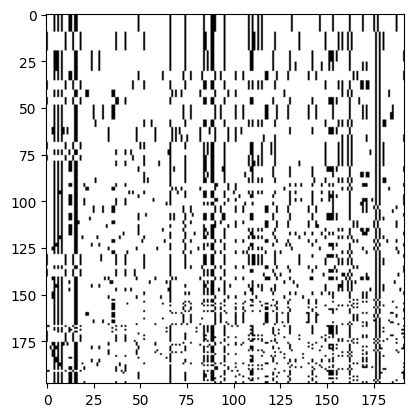

100


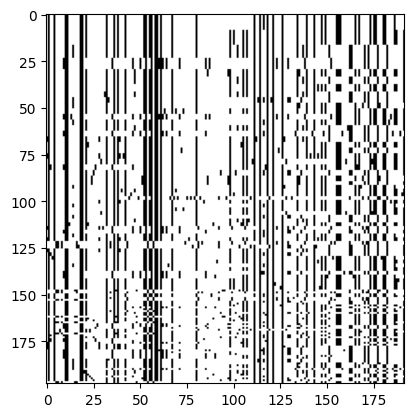

In [10]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [11]:
# Subset the simulation data with random indices
gene_sim.subset(get_index_random(gene_sim))

# Convert targets to binary format
gene_sim.targets = to_binary(gene_sim.targets)


In [12]:

# Load the pre-trained model from the parent directory
base_model = load_model('../RS.binary.h5')

# Freeze fewer initial layers of the base model
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

# Add new layers on top of the pre-trained model for fine-tuning
model = models.Sequential([
    base_model,  # The pre-trained model is added as the base
    layers.Flatten(),  # Flatten the output from the base model to feed into dense layers
    layers.Dense(units=128, activation='relu'),  # New dense layer with 128 units and ReLU activation
    layers.BatchNormalization(),  # Batch Normalization for improved training
    layers.Dropout(0.5),  # Dropout for regularization to prevent overfitting
    layers.Dense(units=128, activation='relu'),  # Additional dense layer
    layers.BatchNormalization(),  # Batch Normalization for improved training
    layers.Dropout(0.5),  # Dropout for regularization to prevent overfitting
    layers.Dense(units=128, activation='relu'),  # Another dense layer
    layers.BatchNormalization(),  # Batch Normalization for improved training
    layers.Dropout(0.5),  # Dropout for regularization to prevent overfitting
    layers.Dense(units=1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with an adjusted learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Summary of the model to show its architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 4173473   
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 128)               256       
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                        

In [13]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

57/57 [==============================] - 162s 3s/step - loss: 1.0265 - accuracy: 0.5008 - val_loss: 0.9058 - val_accuracy: 0.4825


In [14]:
net_LCT = ImaNet(name='BaseModel_FineTuned_D128')


In [15]:
net_LCT.update_scores(score);

2
57/57 [==============================] - 161s 3s/step - loss: 0.9170 - accuracy: 0.5036 - val_loss: 0.9005 - val_accuracy: 0.4925
3
57/57 [==============================] - 162s 3s/step - loss: 0.9101 - accuracy: 0.4922 - val_loss: 0.8960 - val_accuracy: 0.5225
4
57/57 [==============================] - 167s 3s/step - loss: 0.9047 - accuracy: 0.4947 - val_loss: 0.8926 - val_accuracy: 0.4675
5
57/57 [==============================] - 166s 3s/step - loss: 0.8966 - accuracy: 0.4989 - val_loss: 0.8874 - val_accuracy: 0.5200
6
57/57 [==============================] - 164s 3s/step - loss: 0.8914 - accuracy: 0.5050 - val_loss: 0.8838 - val_accuracy: 0.4975
7
57/57 [==============================] - 161s 3s/step - loss: 0.8875 - accuracy: 0.4992 - val_loss: 0.8804 - val_accuracy: 0.4550
8
57/57 [==============================] - 164s 3s/step - loss: 0.8827 - accuracy: 0.4847 - val_loss: 0.8764 - val_accuracy: 0.4725
9
57/57 [==============================] - 160s 3s/step - loss: 0.8780 - acc

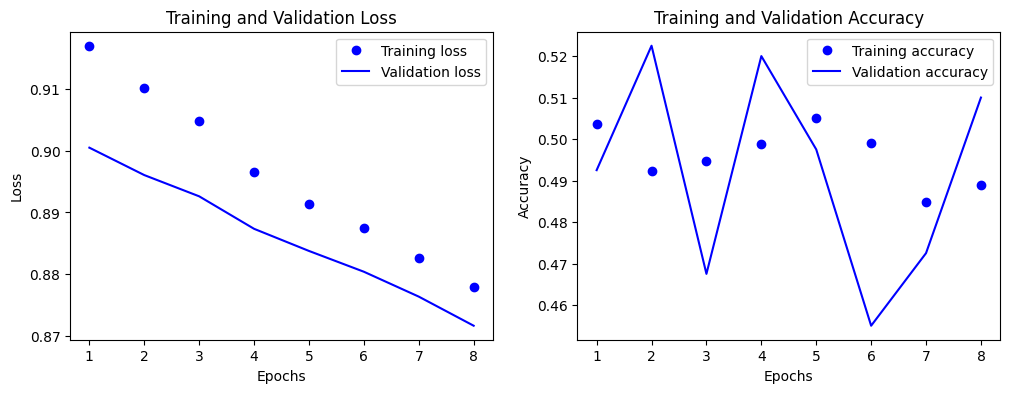

In [16]:
i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Loop to iterate through different simulation datasets
while i < 10:
    print(i)

    # Create ImaFile object for the specified simulation folder and model
    file_sim = ImaFile(simulations_folder=path_sim + 'RW/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # Read the simulation data
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    # Filter simulations based on frequency threshold
    gene_sim.filter_freq(0.01)

    # Sort simulations by row frequency
    gene_sim.sort('rows_freq')

    # Resize simulation data to the required dimensions
    gene_sim.resize((198, 192))

    # Convert simulation data (flip=True allows for data augmentation)
    gene_sim.convert(flip=True)

    # Get a random subset of indices and subset the simulation data
    gene_sim.subset(get_index_random(gene_sim))

    # Convert targets to binary format
    gene_sim.targets = to_binary(gene_sim.targets)

    # Train the model on the current subset of simulation data
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

    # Update scores with the current training results
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    # Increment the index for the next iteration
    i += 1

# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Create a figure for plotting
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, all_scores['loss'], 'bo', label='Training loss')
plt.plot(epochs, all_scores['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, all_scores['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, all_scores['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()

Evaluate the training on the testing dataset, Which is the last batch of the the 10th simulation in the file
The log the testing validation and loss alongside the F1,

In [17]:
# Set the simulation index
i = 10

# Create an ImaFile object for the specified simulation folder and model
file_sim = ImaFile(simulations_folder=path_sim + 'RW/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data with the specified parameter and maximum number of replicates
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

# Filter the simulations based on a frequency threshold of 0.01
gene_sim_test.filter_freq(0.01)

# Sort the simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the specified dimensions (198, 192)
gene_sim_test.resize((198, 192))

# Convert the simulation data with data augmentation (flip=True)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
rnd_idx = get_index_random(gene_sim_test)  # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


In [18]:
# Evaluate the model on the test data to obtain loss and accuracy
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)

# Print the evaluation results, which include loss and accuracy
print(net_LCT.test)  # It will report [loss, accuracy]


[0.8718690872192383, 0.5]


125/125 [==============================] - 51s 404ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


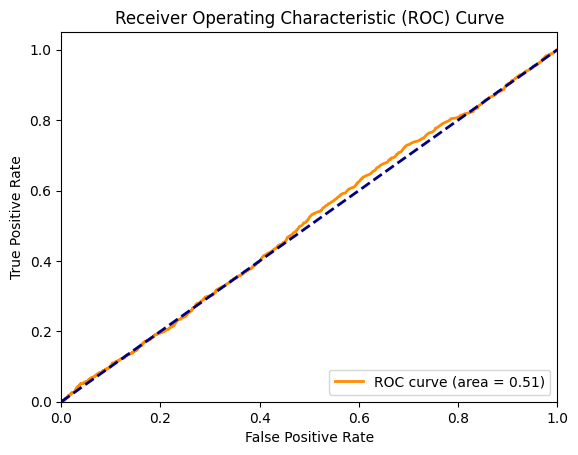

F1 Score: 0.0
Precision: 0.0
Recall (Sensitivity): 0.0


In [19]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

125/125 [==============================] - 50s 397ms/step


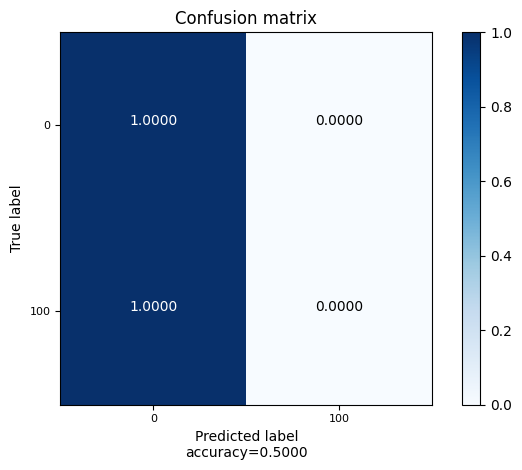

0

In [20]:
# Make predictions on the test data using the trained model and store the results in net_LCT
net_LCT.predict(gene_sim_test, model)

# Plot the confusion matrix of the predictions against the true classes, with text labels for clarity
net_LCT.plot_cm(gene_sim_test.classes, text=True)


In [21]:
path = './'
filename = 'RW_transfer_learning.keras'

# Save the trained model to a file using the recommended Keras format
model.save(path + filename)

In [26]:

# Paths
path = './'
filename = 'RW_transfer_learning.keras'

# Define the model-building function for Keras Tuner
def model_builder(hp):
    # Load your pre-trained model
    base_model = load_model(path + filename)
    base_model.trainable = False  # Freeze the pre-trained layers

    model = keras.Sequential()
    model.add(base_model)

    # Hyperparameter: Number of additional layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=5)

    for i in range(num_layers):
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=1024, step=16)
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

        # Hyperparameter: Dropout Rate for each layer
        hp_dropout = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.8, step=0.05)
        model.add(keras.layers.Dropout(rate=hp_dropout))

    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Hyperparameter: Learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30, # Total budget
                     factor=3,
                     directory='my_dir',
                     project_name='RW_transfer_learning')

# Train on batches 1-7
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

for i in range(1, 8):
    print(f"Training on batch {i}")

    # Create ImaFile object for the specified simulation folder and model
    file_sim = ImaFile(simulations_folder=path_sim + 'RW/Simulations' + str(i),
                       nr_samples=198, model_name='Marth-3epoch-CEU')

    # Read the simulation data
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    # Filter simulations based on frequency threshold
    gene_sim.filter_freq(0.01)

    # Sort simulations by row frequency
    gene_sim.sort('rows_freq')

    # Resize simulation data to the required dimensions
    gene_sim.resize((198, 192))

    # Convert simulation data (flip=True allows for data augmentation)
    gene_sim.convert(flip=True)

    # Get a random subset of indices and subset the simulation data
    gene_sim.subset(get_index_random(gene_sim))

    # Convert targets to binary format
    gene_sim.targets = to_binary(gene_sim.targets)

    # Run the Keras Tuner search
    tuner.search(gene_sim.data, gene_sim.targets, epochs=1, validation_split=0.10, batch_size=32)

    # Clear session to release memory
    K.clear_session()

# Test on batch 8
print("Testing on batch 8")
file_sim_test = ImaFile(simulations_folder=path_sim + 'RW/Simulations8',
                        nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data
gene_sim_test = file_sim_test.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

# Filter simulations based on frequency threshold
gene_sim_test.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize simulation data to the required dimensions
gene_sim_test.resize((198, 192))

# Convert simulation data (flip=True allows for data augmentation)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
gene_sim_test.subset(get_index_random(gene_sim_test))

# Convert targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)

best_hps = tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Evaluate the model on batch 8
test_loss, test_acc = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=32)

print(f"""
The optimal configuration is:
- Number of dense layers: {best_hps.get('num_layers')}
- Units per dense layer: {best_hps.get('units')}
- Dropout rate: {best_hps.get('dropout')}
- Learning rate: {best_hps.get('learning_rate')}

Test Accuracy on batch 8: {test_acc}
""")

# Save the tuned model
model.save(path + 'tuned_' + filename)